In [1]:
!pip install requests tqdm trimesh thingi10k numpy-stl numpy py7zr
!pip install fast-simplification

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 4.6 MB/s eta 0:00:0015.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [py7zr]━━━━━ 6/8 [inflate64]efile]


In [1]:
import os
import sys
import zipfile
import shutil
import requests
import tempfile
import logging
import time
import platform
import urllib.request
from urllib.parse import urlencode
from concurrent.futures import (
    ThreadPoolExecutor,
    ProcessPoolExecutor,
    as_completed,
)
from tqdm import tqdm
import multiprocessing

# Mesh processing libraries
import trimesh
import numpy as np
from stl import mesh
import thingi10k
import scipy.io
import py7zr  # Added for ABC dataset extraction

In [ ]:

# Setup clear logging
logging.basicConfig(level=logging.INFO, format="[%(levelname)s] %(message)s")

# ---------------------------------------------------------------------------------
# Worker functions (must be at the module's top level for process pools to work)
# ---------------------------------------------------------------------------------

def _download_worker(url, filename, chunk_size=8192):
    """Securely downloads a file, supporting HTTP/S and FTP."""
    try:
        if url.startswith("ftp://"):
            urllib.request.urlretrieve(url, filename)
        else:
            with requests.get(url, stream=True, timeout=30) as r:
                r.raise_for_status()
                total_size = int(r.headers.get("content-length", 0))
                with open(filename, "wb") as f, tqdm(
                    total=total_size, unit="B", unit_scale=True, leave=False, desc=os.path.basename(filename)
                ) as pbar:
                    for chunk in r.iter_content(chunk_size=chunk_size):
                        f.write(chunk)
                        pbar.update(len(chunk))
        return filename, None
    except Exception as e:
        if os.path.exists(filename):
            try:
                os.remove(filename)
            except OSError:
                pass
        return filename, str(e)

def _convert_to_stl_worker(src_path, dst_path, target_faces=2048):
    """Loads any mesh file, simplifies it if needed, and saves as STL."""
    try:
        mesh_obj = trimesh.load_mesh(src_path)
        
        if isinstance(mesh_obj, trimesh.Scene):
            if len(mesh_obj.geometry) > 0:
                mesh_obj = trimesh.util.concatenate(
                    tuple(trimesh.Trimesh(vertices=g.vertices, faces=g.faces)
                          for g in mesh_obj.geometry.values()))
            else:
                return src_path, "Scene is empty"

        if isinstance(mesh_obj, trimesh.Trimesh) and len(mesh_obj.faces) > target_faces:
            mesh_obj = mesh_obj.simplify_quadric_decimation(face_count=target_faces)
        
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        mesh_obj.export(dst_path)
        return src_path, None
    except Exception as e:
        return src_path, str(e)

def _thingi10k_worker(npz_path, dst_path, target_faces=2048):
    """Worker for Thingi10k: loads .npz, converts, simplifies, and saves."""
    try:
        if os.path.exists(dst_path):
            return npz_path, None
        with np.load(npz_path) as data:
            vertices = np.asarray(data["vertices"], dtype=np.float64)
            facets = np.asarray(data["facets"], dtype=np.int32)
        
        if vertices.shape[0] < 3 or facets.shape[0] == 0:
            return npz_path, "Insufficient geometry"
            
        mesh_obj = trimesh.Trimesh(vertices=vertices, faces=facets)
        
        if len(mesh_obj.faces) > target_faces:
            mesh_obj = mesh_obj.simplify_quadric_decimation(face_count=target_faces)
            
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        mesh_obj.export(dst_path)
        return npz_path, None
    except Exception as e:
        return npz_path, str(e)

def _process_shapenet_model_worker(zip_filepath, category_id, model_id, models_dir, images_dir, target_faces):
    """Worker to process a single model from a ShapeNet zip file."""
    temp_obj_path = ""
    try:
        with zipfile.ZipFile(zip_filepath, 'r') as z:
            all_files = z.namelist()
            
            model_prefix = f"{category_id}/{model_id}/models/"
            model_norm = f"{model_prefix}model_normalized.obj"
            model_path_in_zip = model_norm if model_norm in all_files else next(
                (f for f in all_files if f.startswith(model_prefix) and f.endswith(".obj")), None
            )
            if not model_path_in_zip:
                return model_id, "No .obj file found"
                
            pid = os.getpid()
            temp_obj_path = os.path.join(tempfile.gettempdir(), f"shapenet_{pid}_{model_id}.obj")
            with z.open(model_path_in_zip) as source, open(temp_obj_path, "wb") as target:
                shutil.copyfileobj(source, target)
            
            dst_stl_path = os.path.join(models_dir, f"{model_id}.stl")
            _, error = _convert_to_stl_worker(temp_obj_path, dst_stl_path, target_faces)
            if error:
                return model_id, error

            screenshot_prefix = f"{category_id}/{model_id}/screenshots/"
            screenshot_files = [f for f in all_files if f.startswith(screenshot_prefix) and (f.endswith((".png", ".jpg")))]
            
            for i, screenshot_path in enumerate(screenshot_files):
                ext = ".png" if screenshot_path.endswith(".png") else ".jpg"
                img_dest_path = os.path.join(images_dir, f"{model_id}_{i}{ext}")
                with z.open(screenshot_path) as source, open(img_dest_path, "wb") as target:
                    shutil.copyfileobj(source, target)
                    
        return model_id, None
    except Exception as e:
        return model_id, str(e)
    finally:
        if os.path.exists(temp_obj_path):
            os.remove(temp_obj_path)

def _extract_7z_worker(archive_path, extract_to):
    """Extracts a .7z archive to a specified directory."""
    try:
        with py7zr.SevenZipFile(archive_path, mode='r') as z:
            z.extractall(path=extract_to)
        return archive_path, None
    except Exception as e:
        return archive_path, str(e)

# ---------------------------------------------------------------------------------
# DatasetsManager Class
# ---------------------------------------------------------------------------------
class DatasetsManager:
    """Manages downloading, processing, and structuring of 3D datasets with parallel execution."""
    
    def __init__(self, root_dir="data", max_workers=None, target_faces=2048):
        self.root_dir = root_dir
        self.target_faces = target_faces
        os.makedirs(self.root_dir, exist_ok=True)

        cpu_count = os.cpu_count() or 4
        self.max_workers = max_workers or cpu_count
        self.max_io_workers = self.max_workers * 2

        logging.info(f"Initialized DatasetsManager in '{self.root_dir}'")
        logging.info(f"Using up to {self.max_workers} CPU workers and {self.max_io_workers} IO workers.")
        logging.info(f"All models will be simplified to a maximum of {self.target_faces} faces.")

        self.config = {
            "thingi10k": {"path": os.path.join(root_dir, "thingi10k")},
            "modelnet": {"path": os.path.join(root_dir, "modelnet40"), "url": "http://modelnet.cs.princeton.edu/ModelNet40.zip"},
            "abc": {"path": os.path.join(root_dir, "abc_dataset"), "manifest_url": "https://deep-geometry.github.io/abc-dataset/data/stl2_v00.txt"},
            "objectnet": {
                "path": os.path.join(root_dir, "objectnet3d"),
                "urls": {
                    "annotations": "ftp://cs.stanford.edu/cs/cvgl/ObjectNet3D/ObjectNet3D_annotations.zip",
                    "cads": "ftp://cs.stanford.edu/cs/cvgl/ObjectNet3D/ObjectNet3D_cads.zip",
                    "images": "ftp://cs.stanford.edu/cs/cvgl/ObjectNet3D/ObjectNet3D_images.zip",
                }
            },
            "shapenet": {"path": os.path.join(root_dir, "shapenet"), "repo_id": "ShapeNet/ShapeNetCore"},
            "custom": {"path": os.path.join(root_dir, "custom_dataset"), "urls": {"train_data": "https://disk.yandex.ru/d/RRXJu9ZtEmSXzQ", "test_data": "https://disk.yandex.ru/d/TmbB7BsGzg1dQQ"}}
        }
    
    def _get_process_pool(self):
        try:
            context = multiprocessing.get_context("spawn")
            return ProcessPoolExecutor(max_workers=self.max_workers, mp_context=context)
        except Exception:
            logging.warning("ProcessPoolExecutor failed. Falling back to ThreadPoolExecutor for CPU tasks (slower).")
            return None

    def _parallel_execute(self, jobs, desc, is_io_bound=False):
        results = {}
        if not jobs:
            return results
        
        use_processes = not is_io_bound and self._get_process_pool() is not None
        Executor = ProcessPoolExecutor if use_processes else ThreadPoolExecutor
        max_workers = self.max_workers if use_processes else self.max_io_workers
        
        with Executor(max_workers=max_workers) as pool:
            futures = {pool.submit(job[0], *job[1]): job for job in jobs}
            
            for future in tqdm(as_completed(futures), total=len(jobs), desc=desc):
                original_job = futures[future]
                try:
                    key, error = future.result()
                    if error:
                        logging.warning(f"Task failed for '{key}': {error}")
                    results[key] = error
                except Exception as e:
                    key = original_job[1][0] 
                    logging.error(f"Task for '{key}' raised an exception: {e}")
                    results[key] = str(e)
        return results
        
    def prepare_all_datasets(self):
        pipeline = [
            self.prepare_thingi10k,
            self.prepare_modelnet40,
            self.prepare_abc_dataset,
            self.prepare_objectnet3d,
            self.prepare_shapenet,
            self.prepare_custom_dataset,
        ]
        for i, func in enumerate(pipeline, 1):
            logging.info(f"--- [{i}/{len(pipeline)}] Starting: {func.__name__} ---")
            try:
                func()
            except Exception as e:
                logging.error(f"FATAL ERROR in {func.__name__}: {e}", exc_info=True)
            logging.info(f"--- Finished: {func.__name__} ---")
        logging.info("All dataset preparations complete.")

    def prepare_thingi10k(self):
        path = self.config["thingi10k"]["path"]
        models_out_dir = os.path.join(path, "models")
        os.makedirs(models_out_dir, exist_ok=True)
        try:
            thingi10k.init()
        except Exception as e:
            logging.error(f"Thingi10k initialization failed: {e}")
            return
        jobs = []
        for entry in tqdm(thingi10k.dataset(), desc="Collecting Thingi10k jobs"):
            npz_path, file_id = entry.get("file_path"), entry.get("file_id")
            if not npz_path or not file_id: continue
            dst_path = os.path.join(models_out_dir, f"{file_id}.stl")
            if not os.path.exists(dst_path):
                jobs.append((_thingi10k_worker, (npz_path, dst_path, self.target_faces)))
        if not jobs:
            logging.info("Thingi10k is already up to date.")
            return
        self._parallel_execute(jobs, "Processing Thingi10k")

    def prepare_modelnet40(self):
        cfg = self.config["modelnet"]
        out_dir = cfg["path"]
        if os.path.exists(out_dir) and any(os.scandir(out_dir)):
            logging.info("ModelNet40 appears processed. Skipping.")
            return
        with tempfile.TemporaryDirectory() as temp_dir:
            zip_path = os.path.join(temp_dir, "ModelNet40.zip")
            logging.info("Downloading ModelNet40...")
            _, error = _download_worker(cfg["url"], zip_path)
            if error:
                logging.error(f"Failed to download ModelNet40: {error}")
                return
            logging.info("Extracting ModelNet40...")
            with zipfile.ZipFile(zip_path, 'r') as z:
                z.extractall(temp_dir)
            source_dir = os.path.join(temp_dir, "ModelNet40")
            if not os.path.exists(source_dir):
                logging.error("Extracted 'ModelNet40' folder not found.")
                return
            jobs = []
            for cat_dir in os.scandir(source_dir):
                if not cat_dir.is_dir(): continue
                for split in ["train", "test"]:
                    split_dir = os.path.join(cat_dir.path, split)
                    if not os.path.exists(split_dir): continue
                    for off_file in os.scandir(split_dir):
                        if off_file.name.endswith(".off"):
                            dst_path = os.path.join(out_dir, cat_dir.name, "models", off_file.name.replace(".off", ".stl"))
                            if not os.path.exists(dst_path):
                                jobs.append((_convert_to_stl_worker, (off_file.path, dst_path, self.target_faces)))
            if jobs:
                self._parallel_execute(jobs, "Processing ModelNet40")

    def prepare_abc_dataset(self, count_archives=10):
        cfg = self.config["abc"]
        models_out_dir = os.path.join(cfg["path"], "models")
        os.makedirs(models_out_dir, exist_ok=True)
        if os.path.exists(models_out_dir) and len(os.listdir(models_out_dir)) > 1000:
             logging.info("ABC dataset appears to be processed. Skipping.")
             return
        with tempfile.TemporaryDirectory(prefix="abc_dataset_") as temp_dir:
            logging.info("Downloading ABC dataset manifest...")
            manifest_path = os.path.join(temp_dir, "stl2_v00.txt")
            _, error = _download_worker(cfg["manifest_url"], manifest_path)
            if error:
                logging.error(f"Failed to download ABC manifest: {error}")
                return
            
            download_jobs = []
            with open(manifest_path, 'r') as f:
                urls = [line.strip().split()[0] for line in f if line.strip()]
            
            for i, url in enumerate(urls[:count_archives]):
                archive_path = os.path.join(temp_dir, f"abc_{i}.7z")
                if not os.path.exists(archive_path):
                    download_jobs.append((_download_worker, (url, archive_path)))

            if download_jobs:
                self._parallel_execute(download_jobs, "Downloading ABC archives", is_io_bound=True)

            extraction_jobs = [( _extract_7z_worker, (os.path.join(temp_dir, f), temp_dir))
                               for f in os.listdir(temp_dir) if f.endswith(".7z")]
            if extraction_jobs:
                self._parallel_execute(extraction_jobs, "Extracting ABC archives")

            final_jobs = []
            for root, _, files in os.walk(temp_dir):
                for file in files:
                    if file.endswith(".stl"):
                        src_path = os.path.join(root, file)
                        dst_path = os.path.join(models_out_dir, file)
                        if not os.path.exists(dst_path):
                            # ABC models are already STL, so we just copy and simplify
                            final_jobs.append((_convert_to_stl_worker, (src_path, dst_path, self.target_faces)))
            if final_jobs:
                self._parallel_execute(final_jobs, "Simplifying and moving ABC models")

    def prepare_objectnet3d(self):
        """Downloads, extracts, converts, and links ObjectNet3D data."""
        cfg = self.config["objectnet"]
        out_dir = cfg["path"]
        if os.path.exists(out_dir) and any(os.scandir(out_dir)):
            logging.info("ObjectNet3D directory not empty; skipping.")
            return

        with tempfile.TemporaryDirectory(prefix="objectnet_") as temp_dir:
            # 1. Download all zip files in parallel
            download_jobs = []
            for name, url in cfg["urls"].items():
                zip_path = os.path.join(temp_dir, f"{name}.zip")
                download_jobs.append((_download_worker, (url, zip_path)))
            
            self._parallel_execute(download_jobs, "Downloading ObjectNet3D", is_io_bound=True)

            # 2. Extract all zip files serially
            for name in cfg["urls"]:
                zip_path = os.path.join(temp_dir, f"{name}.zip")
                if os.path.exists(zip_path):
                    with zipfile.ZipFile(zip_path, 'r') as z:
                        z.extractall(temp_dir)
            
            # 3. Collect and run CAD conversion jobs in parallel
            source_cad_dir = os.path.join(temp_dir, "ObjectNet3D", "CAD", "off")
            conversion_jobs = []
            if os.path.exists(source_cad_dir):
                for cat_dir in os.scandir(source_cad_dir):
                    if not cat_dir.is_dir(): continue
                    for off_file in os.scandir(cat_dir.path):
                        if off_file.name.endswith(".off"):
                            dst_path = os.path.join(out_dir, cat_dir.name, "models", off_file.name.replace(".off", ".stl"))
                            if not os.path.exists(dst_path):
                                conversion_jobs.append((_convert_to_stl_worker, (off_file.path, dst_path, self.target_faces)))
            if conversion_jobs:
                self._parallel_execute(conversion_jobs, "Processing ObjectNet3D CADs")

            # 4. Link images based on annotations serially
            ann_dir = os.path.join(temp_dir, "ObjectNet3D", "Annotations")
            img_dir = os.path.join(temp_dir, "ObjectNet3D", "Images")
            if os.path.exists(ann_dir) and os.path.exists(img_dir):
                for mat_file in tqdm(os.scandir(ann_dir), desc="Linking ObjectNet3D Images"):
                    if not mat_file.name.endswith(".mat"): continue
                    try:
                        mat = scipy.io.loadmat(mat_file.path)
                        record = mat["record"][0, 0]
                        img_filename = str(record["filename"][0])
                        
                        # Handle multiple objects in one image; link to all relevant categories
                        for obj in record["objects"][0]:
                            category_name = str(obj["class"][0])
                            src_img_path = os.path.join(img_dir, img_filename)
                            if os.path.exists(src_img_path):
                                dest_img_dir = os.path.join(out_dir, category_name, "images")
                                os.makedirs(dest_img_dir, exist_ok=True)
                                shutil.copy2(src_img_path, os.path.join(dest_img_dir, img_filename))
                    except Exception as e:
                        logging.warning(f"Could not process annotation {mat_file.name}: {e}")

    def prepare_shapenet(self):
        cfg = self.config["shapenet"]
        out_dir = cfg["path"]
        hf_token = os.environ.get("HF_TOKEN")
        if not hf_token:
            logging.warning("HF_TOKEN environment variable not set. Skipping ShapeNet.")
            return
        try:
            from huggingface_hub import login, snapshot_download
            login(token=hf_token)
            cache_dir = snapshot_download(repo_id=cfg["repo_id"], repo_type="dataset")
        except Exception as e:
            logging.error(f"Could not download ShapeNet from Hugging Face: {e}")
            return
        zip_files = sorted([f for f in os.listdir(cache_dir) if f.endswith(".zip")])
        for zip_filename in tqdm(zip_files, desc="Processing ShapeNet Categories"):
            category_id = zip_filename.replace(".zip", "")
            models_out_dir = os.path.join(out_dir, category_id, "models")
            if os.path.exists(models_out_dir) and any(os.scandir(models_out_dir)):
                continue
            images_out_dir = os.path.join(out_dir, category_id, "images")
            os.makedirs(models_out_dir, exist_ok=True)
            os.makedirs(images_out_dir, exist_ok=True)
            zip_filepath = os.path.join(cache_dir, zip_filename)
            jobs = []
            try:
                with zipfile.ZipFile(zip_filepath, 'r') as z:
                    all_files = z.namelist()
                    model_ids = sorted(list({f.split('/')[1] for f in all_files if f.count('/') >= 2}))
                    for model_id in model_ids:
                        screenshot_prefix = f"{category_id}/{model_id}/screenshots/"
                        if any(f.startswith(screenshot_prefix) for f in all_files):
                            jobs.append((_process_shapenet_model_worker, (zip_filepath, category_id, model_id, models_out_dir, images_out_dir, self.target_faces)))
            except Exception as e:
                 logging.error(f"Failed to read zip {zip_filename}: {e}")
                 continue
            if jobs:
                self._parallel_execute(jobs, f"Processing models in {category_id}")
            if not any(os.scandir(models_out_dir)):
                logging.info(f"Removing empty category directory: {category_id}")
                shutil.rmtree(os.path.join(out_dir, category_id), ignore_errors=True)

    def prepare_custom_dataset(self):
        cfg = self.config["custom"]
        out_dir = cfg["path"]
        if os.path.exists(out_dir) and any(os.scandir(out_dir)):
            logging.info("Custom dataset directory not empty. Skipping.")
            return
        download_jobs = []
        for name, public_url in cfg["urls"].items():
            try:
                api_url = f"https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={public_url}"
                response = requests.get(api_url, timeout=15)
                response.raise_for_status()
                href = response.json().get("href")
                if href:
                    zip_path = os.path.join(self.root_dir, f"temp_{name}.zip")
                    download_jobs.append((_download_worker, (href, zip_path)))
            except Exception as e:
                logging.error(f"Could not get Yandex.Disk URL for {name}: {e}")
        if not download_jobs:
            return
        results = self._parallel_execute(download_jobs, "Downloading Custom Data", is_io_bound=True)
        for zip_path, error in results.items():
            if error:
                logging.error(f"Failed to download {os.path.basename(zip_path)}: {error}")
                continue
            try:
                with zipfile.ZipFile(zip_path, 'r') as z:
                    z.extractall(out_dir)
            except Exception as e:
                logging.error(f"Failed to extract {zip_path}: {e}")
            finally:
                if os.path.exists(zip_path):
                    os.remove(zip_path)

if __name__ == "__main__":
    manager = DatasetsManager(root_dir="data", max_workers=4)
    # manager.prepare_all_datasets()
    manager.prepare_objectnet3d()

[INFO] Initialized DatasetsManager in 'data'
[INFO] Using up to 4 CPU workers and 8 IO workers.
[INFO] All models will be simplified to a maximum of 2048 faces.

In [5]:
!pip install torch torchvision numpy trimesh scikit-image matplotlib pillow

  Using cached scikit_image-0.25.2-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2025.6.11-py3-none-any.whl.metadata (32 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 18.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-image] [scikit-image]


In [6]:
import os
import glob
import torch
import numpy as np
import trimesh
from PIL import Image
from skimage.feature import canny
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1. Helper Function to Load and Process 3D Models ---

def sample_points_from_stl(stl_path, num_points=2048):
    """Loads an STL file and samples points from its surface."""
    try:
        mesh = trimesh.load(stl_path, force='mesh')
        points = mesh.sample(num_points)
        return torch.from_numpy(points).float()
    except Exception as e:
        print(f"Warning: Could not load or sample {stl_path}. Error: {e}. Returning None.")
        return None

# --- 2. Augmentation Classes ---

class PointCloudAugmentation:
    """Applies augmentations to a point cloud."""
    def __init__(self, rotation_axis='y', jitter_std=0.01, points_add_remove_ratio=0.1):
        self.rotation_axis = rotation_axis
        self.jitter_std = jitter_std
        self.points_add_remove_ratio = points_add_remove_ratio

    def __call__(self, points):
        # Random Rotation (around vertical 'y' axis)
        theta = np.random.uniform(0, 2 * np.pi)
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        rotation_matrix = torch.tensor([
            [cos_t, 0, sin_t],
            [0, 1, 0],
            [-sin_t, 0, cos_t]
        ], dtype=points.dtype)
        points = points @ rotation_matrix

        # Random Jitter
        jitter = torch.randn_like(points) * self.jitter_std
        points += jitter

        # Randomly Add/Remove Points
        num_points = points.shape[0]
        num_to_modify = int(num_points * self.points_add_remove_ratio)
        
        # Drop
        indices_to_keep = np.random.choice(num_points, num_points - num_to_modify, replace=False)
        points = points[indices_to_keep]

        # Add (by duplicating existing points)
        indices_to_duplicate = np.random.choice(points.shape[0], num_to_modify, replace=True)
        points = torch.cat([points, points[indices_to_duplicate]], dim=0)
        
        return points

def edge_detection_transform(image_tensor):
    """Applies Canny edge detection to a grayscale image tensor."""
    # Convert tensor to numpy: (C, H, W) -> (H, W, C) -> (H, W)
    image_np = image_tensor.squeeze(0).cpu().numpy()
    # Apply Canny
    edges = canny(image_np, sigma=1.0)
    # Convert back to tensor
    return torch.from_numpy(edges).float().unsqueeze(0)

# Define the image augmentation pipeline
image_augmentations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(), # Converts to [0, 1] range
    transforms.RandomAutocontrast(p=0.5),
    transforms.Lambda(edge_detection_transform),
])


# --- 3. The Dataset Classes ---

class BaseCADDataset(Dataset):
    """Abstract base class for CAD datasets."""
    def __init__(self, root_dir, num_points=2048, image_transform=None, model_transform=None):
        self.root_dir = root_dir
        self.num_points = num_points
        self.image_transform = image_transform
        self.model_transform = model_transform
        self.file_pairs = self._load_file_pairs()

    def _load_file_pairs(self):
        # This method must be implemented by subclasses
        raise NotImplementedError

    def __len__(self):
        return len(self.file_pairs)

    def __getitem__(self, idx):
        model_path, image_path, name = self.file_pairs[idx]

        # Load and process model
        points = sample_points_from_stl(model_path, self.num_points)
        if points is None: # Handle loading errors
            return self.__getitem__(np.random.randint(0, len(self)))
        
        if self.model_transform:
            points = self.model_transform(points)

        # Load and process image
        image = Image.open(image_path).convert('RGB')
        if self.image_transform:
            image = self.image_transform(image)
            
        return {
            "name": name,
            "model_points": points,
            "image": image,
            "model_path": str(model_path),
            "image_path": str(image_path),
        }

class InstanceLevelDataset(BaseCADDataset):
    """Dataset for instance-level structure (e.g., Thingi10k).
    data/thingi10k/models/model_1.stl
    data/thingi10k/images/model_1_render_1.jpg
    """
    def _load_file_pairs(self):
        model_dir = os.path.join(self.root_dir, 'models')
        image_dir = os.path.join(self.root_dir, 'images')
        pairs = []
        
        for model_path in Path(model_dir).glob('*.stl'):
            model_name = model_path.stem
            # Find all images for this model
            for image_path in Path(image_dir).glob(f'{model_name}*.png'):
                pairs.append((model_path, image_path, model_name))
            for image_path in Path(image_dir).glob(f'{model_name}*.jpg'):
                pairs.append((model_path, image_path, model_name))

        print(f"Found {len(pairs)} (model, image) pairs in {self.root_dir}")
        return pairs


class CategoryLevelDataset(BaseCADDataset):
    """Dataset for category-level structure (e.g., ModelNet40).
    data/modelnet40/chair/models/chair_1.stl
    data/modelnet40/chair/images/chair_render_1.jpg
    """
    def _load_file_pairs(self):
        pairs = []
        categories = [d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))]
        
        for category in categories:
            category_path = os.path.join(self.root_dir, category)
            model_paths = list(Path(category_path).glob('models/*.stl'))
            image_paths = list(Path(category_path).glob('images/*.png')) + list(Path(category_path).glob('images/*.jpg'))
            
            if not model_paths or not image_paths:
                continue

            # For each model, pair it with a random image from its category
            for model_path in model_paths:
                image_path = np.random.choice(image_paths)
                pairs.append((model_path, image_path, category))

        print(f"Found {len(pairs)} (model, image) pairs in {self.root_dir}")
        return pairs


# --- 4. Usage Example ---

def create_dummy_data(base_dir="data"):
    """Creates a dummy folder structure and files for testing."""
    if os.path.exists(base_dir):
        return # Avoid re-creating
    
    # Instance-level dataset
    thingi_path = Path(base_dir) / "thingi10k"
    (thingi_path / "models").mkdir(parents=True, exist_ok=True)
    (thingi_path / "images").mkdir(parents=True, exist_ok=True)
    trimesh.creation.box().export(thingi_path / "models/box_1.stl")
    trimesh.creation.sphere().export(thingi_path / "models/sphere_2.stl")
    Image.new('RGB', (100, 100)).save(thingi_path / "images/box_1_render_1.jpg")
    Image.new('RGB', (100, 100)).save(thingi_path / "images/box_1_render_2.jpg")
    Image.new('RGB', (100, 100)).save(thingi_path / "images/sphere_2_render_1.jpg")

    # Category-level dataset
    modelnet_path = Path(base_dir) / "modelnet40"
    (modelnet_path / "chair/models").mkdir(parents=True, exist_ok=True)
    (modelnet_path / "chair/images").mkdir(parents=True, exist_ok=True)
    (modelnet_path / "table/models").mkdir(parents=True, exist_ok=True)
    (modelnet_path / "table/images").mkdir(parents=True, exist_ok=True)
    trimesh.creation.box((0.8, 1, 0.8)).export(modelnet_path / "chair/models/chair_1.stl")
    trimesh.creation.cylinder(radius=0.5, height=0.5).export(modelnet_path / "table/models/table_1.stl")
    Image.new('RGB', (100, 100)).save(modelnet_path / "chair/images/chair_view_1.png")
    Image.new('RGB', (100, 100)).save(modelnet_path / "table/images/table_view_1.png")
    print("Dummy data created.")

def visualize_sample(sample):
    """Visualizes a single sample from the dataset."""
    fig = plt.figure(figsize=(10, 5))

    # Plot image
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(sample['image'].squeeze(), cmap='gray')
    ax1.set_title(f"Image: {sample['name']}\nShape: {sample['image'].shape}")
    ax1.axis('off')

    # Plot point cloud (2D projection)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    points = sample['model_points'].numpy()
    ax2.scatter(points[:, 0], points[:, 1], points[:, 2], s=2)
    ax2.set_title(f"Point Cloud: {sample['name']}\nShape: {sample['model_points'].shape}")
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.view_init(elev=30, azim=45)

    plt.tight_layout()
    plt.show()

# 1. Create dummy data to test the script
create_dummy_data(base_dir="data")

# 2. Instantiate augmentations
point_cloud_augmentations = PointCloudAugmentation()

# 3. Instantiate the datasets
print("\n--- Loading Instance-Level Dataset (e.g., Thingi10k) ---")
instance_dataset = InstanceLevelDataset(
    root_dir="data/thingi10k",
    image_transform=image_augmentations,
    model_transform=point_cloud_augmentations
)

print("\n--- Loading Category-Level Dataset (e.g., ModelNet40) ---")
category_dataset = CategoryLevelDataset(
    root_dir="data/modelnet40",
    image_transform=image_augmentations,
    model_transform=point_cloud_augmentations
)

# 4. Show an example from the instance-level dataset
if len(instance_dataset) > 0:
    print("\n--- Example from InstanceLevelDataset ---")
    sample_instance = instance_dataset[0]
    print("Sample keys:", sample_instance.keys())
    print("Name:", sample_instance['name'])
    visualize_sample(sample_instance)

# 5. Show an example from the category-level dataset
if len(category_dataset) > 0:
    print("\n--- Example from CategoryLevelDataset ---")
    sample_category = category_dataset[0]
    print("Sample keys:", sample_category.keys())
    print("Name:", sample_category['name'])
    visualize_sample(sample_category)
    
# 6. Example of using DataLoader
if len(instance_dataset) > 0:
    print("\n--- DataLoader Example ---")
    data_loader = DataLoader(instance_dataset, batch_size=2, shuffle=True)
    batch = next(iter(data_loader))
    print("Batch keys:", batch.keys())
    print("Batch image shape:", batch['image'].shape)
    print("Batch model_points shape:", batch['model_points'].shape)


--- Loading Instance-Level Dataset (e.g., Thingi10k) ---
Found 0 (model, image) pairs in data/thingi10k

--- Loading Category-Level Dataset (e.g., ModelNet40) ---
Found 0 (model, image) pairs in data/modelnet40


In [5]:
import os
import trimesh
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_folder = "data"


def scantree(path):
    """Recursively yield DirEntry objects for given directory."""
    for entry in os.scandir(path):
        if entry.is_dir(follow_symlinks=False):
            yield from scantree(entry.path)  # see below for Python 2.x
        else:
            yield entry


points_counts = {}
for i in os.scandir(data_folder):
    points_counts[i.name] = [len(trimesh.load_mesh(file.path).vertices) for file in scantree(i) if file.name.endswith('.stl')]

    print(f"files in {i.name} = {len(points_counts[i.name])}")


files in custom_dataset = 725
files in thingi10k = 2029


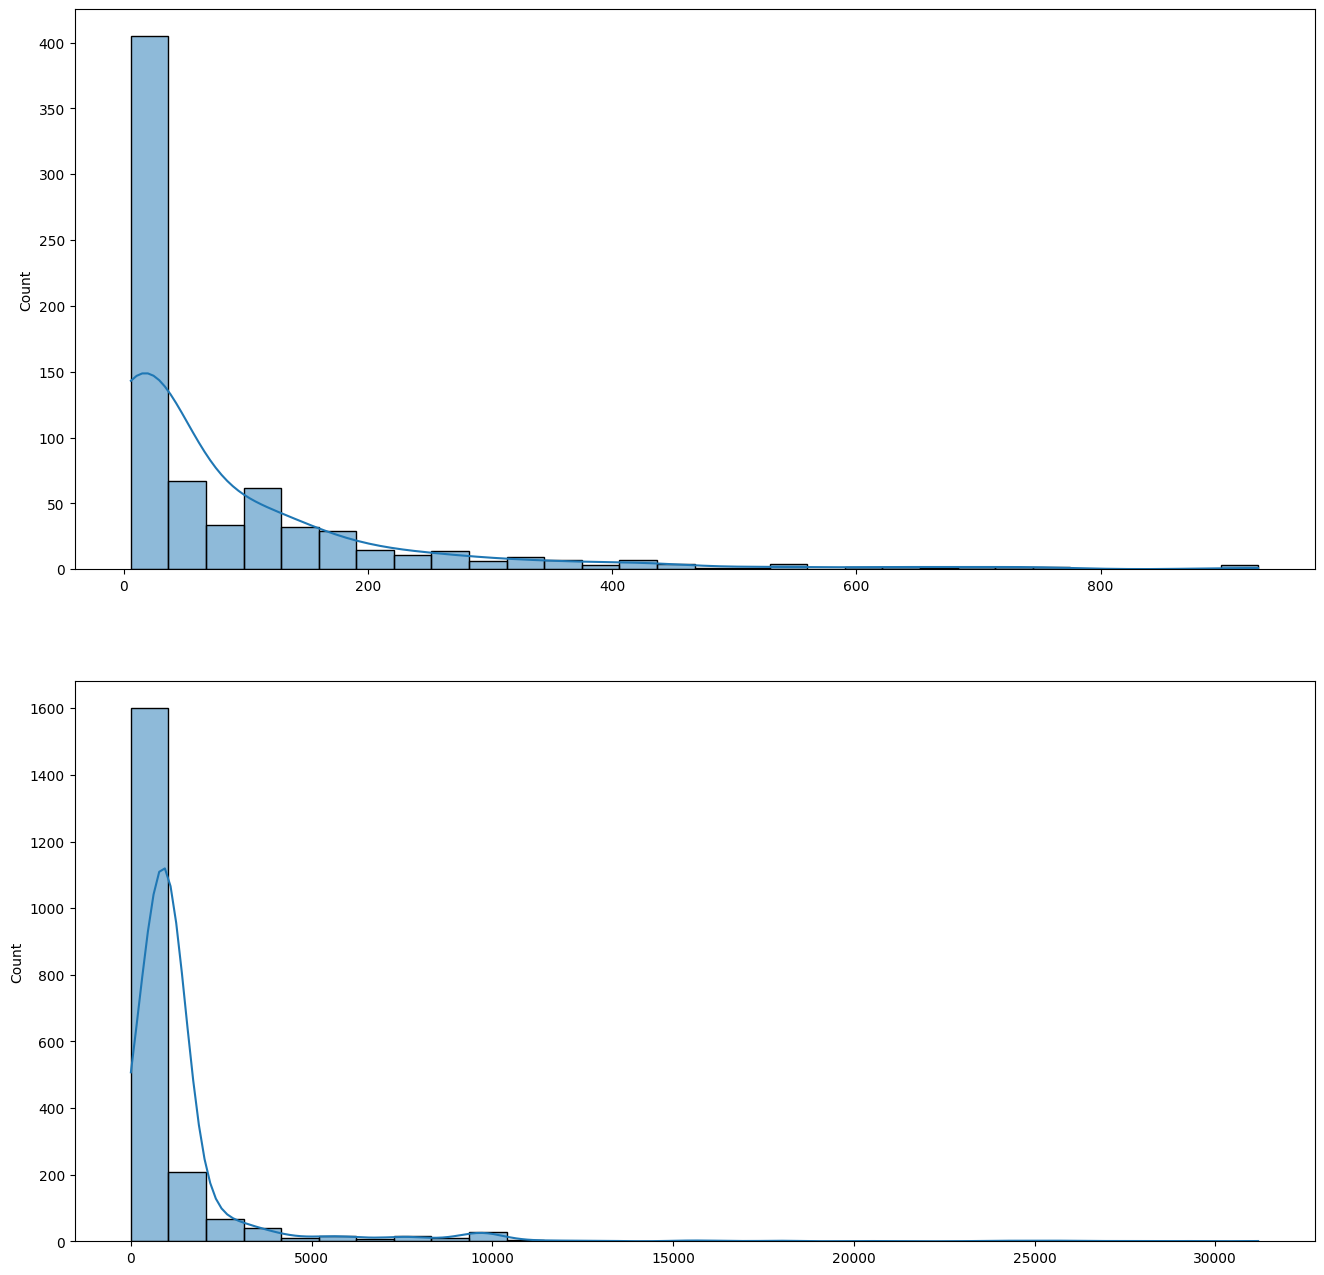

In [8]:

fig, ax = plt.subplots(len(points_counts), figsize=(16, 16))

for i, (k, v) in enumerate(points_counts.items()):
    sns.histplot(v, ax=ax[i], kde=True, bins=30)
plt.show()